In [23]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/brianbarry/Desktop/computing/personal/galaxybrain')
from galaxybrain import ramsey, ising
from galaxybrain.plot_utils import (rc_style, pltlabel, plot_ising_spectra, measure_over_temps, TEMP_COLOR_RANGE, 
                                    colorcycler, noticks,plot_all_measures, normalize_spec, plot_fooof_measures)
rc_style()

import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from matplotlib.colors import ListedColormap as lcmap
import pandas as pd

CRIT_T = 2.26918531421

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ising model and scaling correlation analysis
Hamiltonian – rate of change of the condition of a dynamic physical system, or total energy in the system – is given by

$$ H = -J\sum_{neighbors} s_is_j $$

Summing interactions between [4] neighbors, J (Strength of interaction in Joules) is usually 1 <br>
"In the case of an Ising system, instead of moving a particle, we switch the direction of its spin."

In each monte carlo sweep:
- "Propose" a move: (done in aggregate for each particle)
    - if ∆E < 0  (i.e., the move would bring the system to a state of lower energy; this is desired in physical systems), accept it
    - if ∆E > 0, accept move with probability exp(-∆E/kT) where k is Joules per kelvin.

let's try to do this vectorized

Fricke:  multiply every transition probability by 0.1 to avoid undesirable oscillatory regimes

References:
- [matlab code](https://www.asc.ohio-state.edu/braaten.1/statphys/Ising_MatLab.pdf)
- [python - how to find crit temp](https://rajeshrinet.github.io/blog/2014/ising-model/)

- orioginal tensor shape: (10000, 4096)
- 80% evals shape: 3276
- Taking off the last 2000: 1276

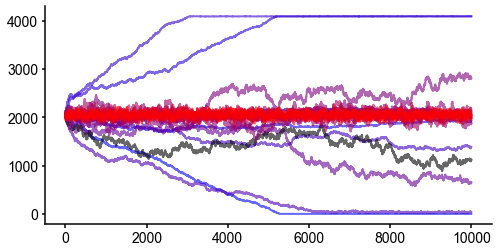

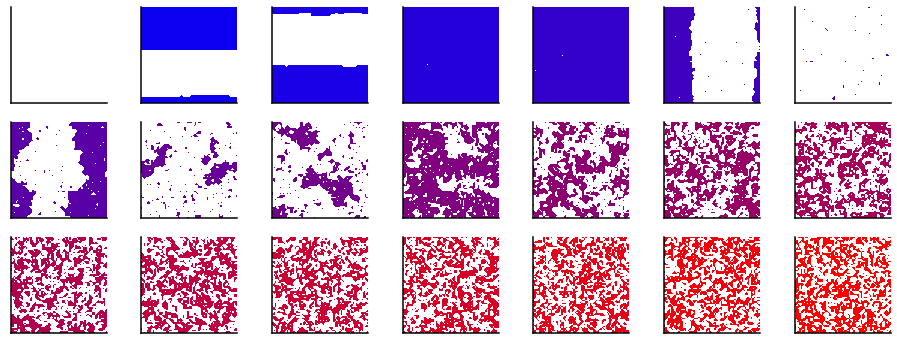

In [2]:
ising_h5 = h5py.File('/Users/brianbarry/Desktop/computing/personal/galaxybrain/data/spikes/ising.hdf5', 'r') 
TEMPS = [float(i) for i in ising_h5.keys()]
COLORS = colorcycler(['blue', 'red'], len(ising_h5.keys()), default=False)
lws = {'2.27':4}
cs = {'2.27':'k'}
# all time series
plt.figure(figsize=(8,4))
for t,c in zip(ising_h5, COLORS):
    plt.plot(np.array(ising_h5[t]).sum(axis=-1).sum(axis=-1), label=t, color=cs.get(t,c), alpha=0.6)

# final frames
plt.figure(figsize=(16,6))
for i, (temp,c) in enumerate(zip(ising_h5, COLORS)):
    plt.subplot(3, 7, i+1)
    plt.imshow(ising_h5[temp][-1], cmap=lcmap(['w', c]))
    noticks()

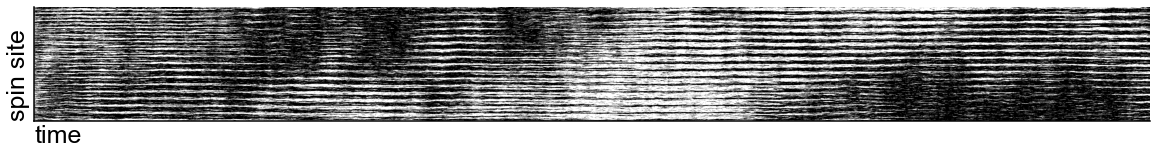

In [365]:
plt.figure(figsize=(20,10))
plt.imshow(ising.tensor_to_raster(ising_h5['2.27'], keep=1024).T)
plt.xlabel('time', loc='left', fontsize=25)
plt.ylabel('spin site', loc='bottom', fontsize=25)
plt.xticks([])
plt.yticks([])
plt.savefig('../fig/ising/ising_raster.png', bbox_inches='tight', pad_inches=0., dpi=400)


# Whole sample spectral analysis


# PSD

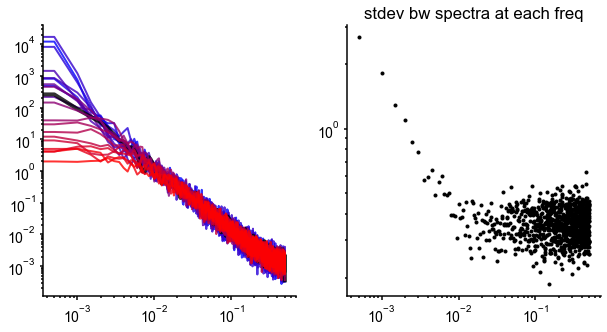

In [3]:
from neurodsp.spectral import compute_spectrum


psds = []
FS       = 1
NPERSEG  = 2000 #400
NOVERLAP = int(.8*NPERSEG)
for temp in ising_h5:
    ts = np.array(ising_h5[temp]).sum(axis=-1).sum(axis=-1)
    freqs, spec = compute_spectrum(ts, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP)
    psds.append(spec)
    
psds = np.array(psds)
normed_psds = np.array([normalize_spec(spec, 400, 800) for spec in psds])
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for spec, t,c in zip(normed_psds, ising_h5, COLORS):
    plt.loglog(freqs, spec, label=t, color=cs.get(t,c), lw=lws.get(t, 2), alpha=0.8)
    
stdevs = np.array([np.std(slice_) for slice_ in np.log(normed_psds.T)])
plt.subplot(1,2,2)
plt.scatter(freqs, stdevs, color='k')
plt.title('stdev bw spectra at each freq')
plt.yscale('log'); plt.xscale('log')


# E Spec

take first n rows (e.g 30  -- > (4000, 30) ) and make sure number of pcs returned is n

64x64 grid with 80% pcs calculated (3276,)


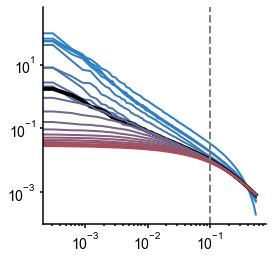

In [4]:

evals_h5 = h5py.File('/Users/brianbarry/Desktop/computing/personal/galaxybrain/data/experiments/ising_pca/ising_evals.hdf5', 'r') # keys := ['1.97', '2.07', '2.17', '2.27', '2.37', '2.47', '2.57']
all_temps = sorted([k for k in evals_h5 if k != 'meta'])

orig_len = evals_h5['2.27'].shape[0]
print('64x64 grid with 80% pcs calculated', evals_h5['2.27'].shape)
evals = np.array([evals_h5[t] for t in all_temps]) #unused
CUT_OFF = -1500
evals_plot = np.array([evals_h5[t][:CUT_OFF] for t in all_temps])
plt.figure()
es_x = np.linspace(0,1, orig_len)
import matplotlib as mpl
colors = colorcycler(TEMP_COLOR_RANGE, len(all_temps), False)
colors[all_temps.index(f'{2.27:.2f}')] = mpl.colors.to_rgba('k')
for e,t,c in zip(evals_plot, all_temps, colors):
    plt.loglog(es_x[:CUT_OFF], normalize_spec(e, 1000, 1700), color=cs.get(t,c), lw=lws.get(t, 2))
    # plt.loglog(es_x[:CUT_OFF], e, color=cs.get(t,c), lw=lws.get(t, 2))
plt.axvline(0.1, ls='dashed', color='gray')

# plt.title(f'x up to {es_x[:CUT_OFF][-1]:.2f}')

plt.savefig('../fig/ising/espec_all.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

## FOOOF measures from whole sample

### PSD

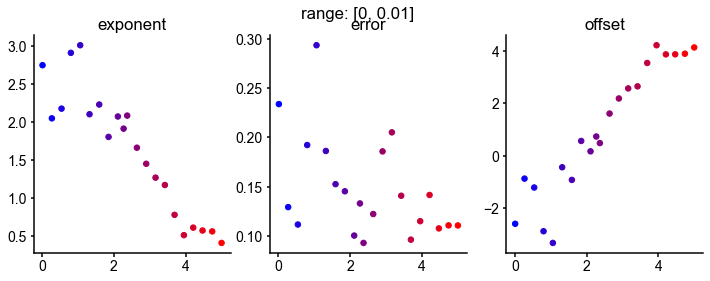

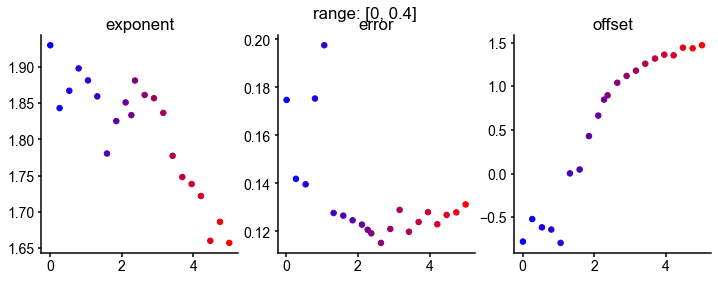

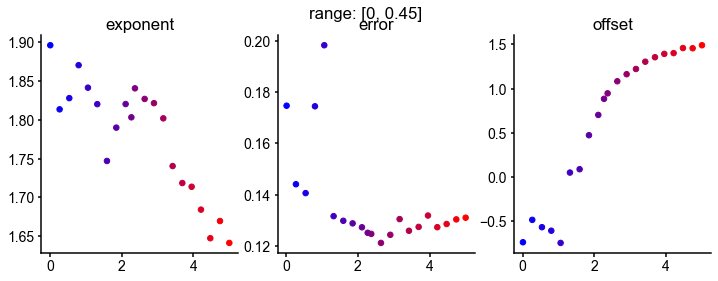

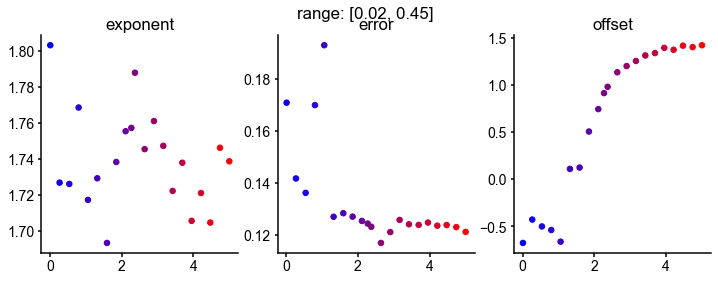

In [31]:
plot_fooof_measures(freqs, psds, [[0, 0.01], [0, 0.4], [0, 0.45], [0.02,0.45]], TEMPS, COLORS)

### ES

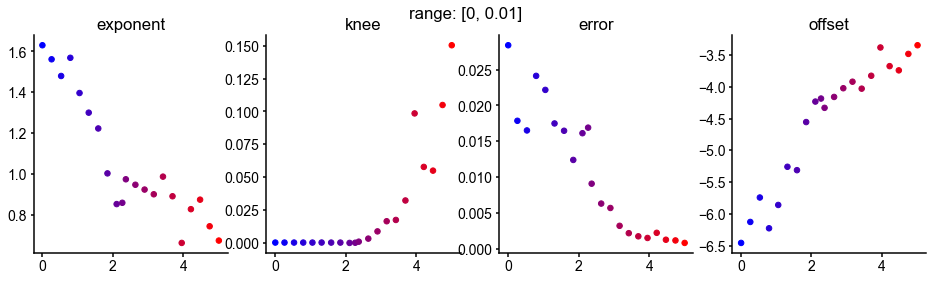

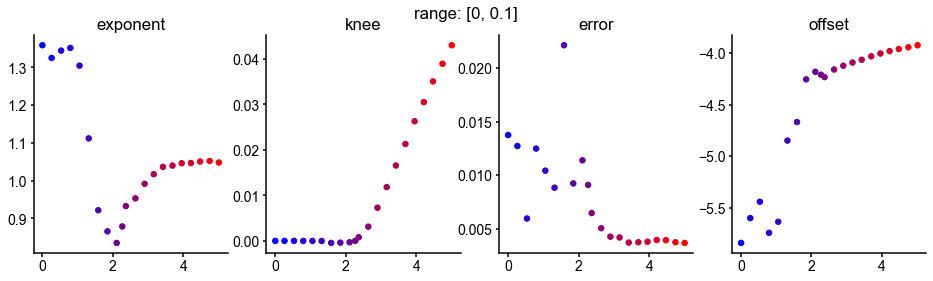

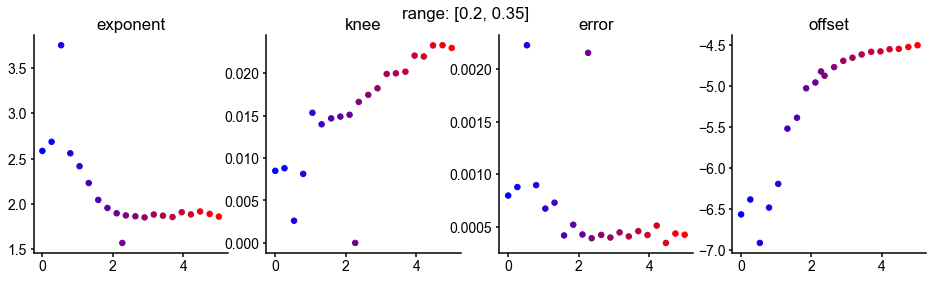

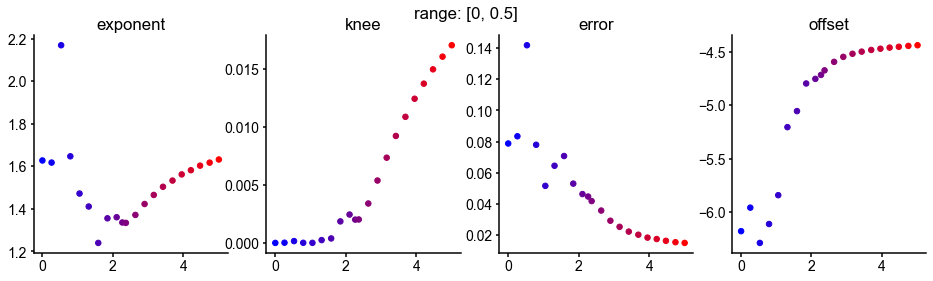

In [30]:
plot_fooof_measures(es_x, evals, 
                    [[0, 0.01], [0, 0.1], [0.2, 0.35], [0,0.5]], TEMPS, COLORS, return_params=[['aperiodic_params', 'exponent'],
                                                                      ['aperiodic_params', 'knee'],
                                                                      ['error'], # MAE
                                                                      ['aperiodic_params', 'offset']], fit_kwargs= {'aperiodic_mode': 'knee'})

# Diagram

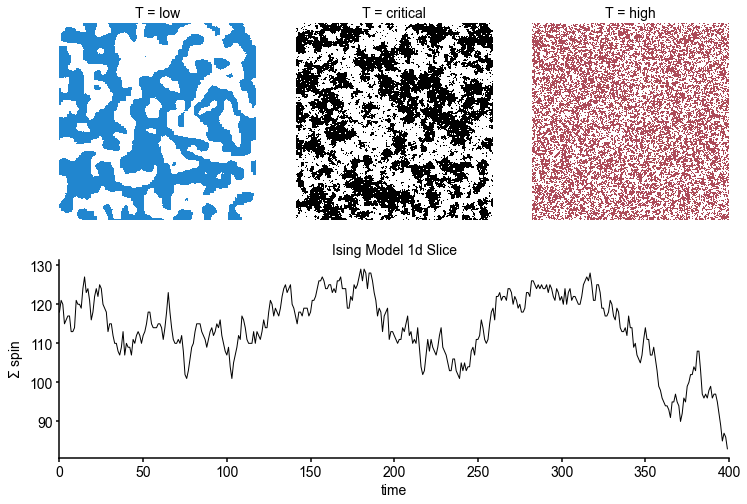

In [19]:
cs = TEMP_COLOR_RANGE[0], 'k', TEMP_COLOR_RANGE[1] #cold, crit, hot
fig = plt.figure(figsize=(12,8))
gs = GridSpec(2,3)
for (i, temp), c in zip(enumerate([0.1, 'critical', 5]), cs):
    # plt.subplot(1,3,i+1)
    ax = fig.add_subplot(gs[0,i])
    grid = ising.metro_ising(N=256, T=temp, runtime=500)
    ax.imshow(grid[499], cmap=lcmap(['w',c])) # plot last frame
    title_map = {0.1:'low', 'critical':'critical', 5:'high'}
    plt.title(f'T = {title_map[temp]}', fontsize=14)
    ax.axis('off')
    if temp == 'critical':
        ax = fig.add_subplot(gs[1,:])
        ising_raster_slice = pd.DataFrame(grid[100:][:,178]) # shape (400, 256)

        ax.plot(np.sum(ising_raster_slice.T), c, lw=1)
        plt.xlim([0,400])
        pltlabel('Ising Model 1d Slice', 'time', r'$\Sigma$ spin')
    
plt.savefig('../fig/ising/grid_samples.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

# Subsampling analysis from cluster

Iterated 4 times for each temperature in: [0.01, 0.27, 0.54, 0.80, 1.06, 1.32, 1.59, 1.85, 2.11, 2.27, 2.37, 2.64, 2.90, 3.16, 3.42, 3.69, 3.95, 4.21, 4.47, 4.74, 5.00]
# parametrization notes
- when `n_pc=0.8` and `pc_range=[0,0.01]`, there arent enough points to fooof fit so skip the first two subsetsizes 30,  301
    - instaed, for now using pc_range up to 0.1 


# TODO
- full temp chart


dimensionality:
- Trials: 4
- bootstrap iterations: 10
- subset sizes (without skipping): 16 (with skipping): 10


In [183]:
from galaxybrain.data_utils import load_results

sim_data = load_results('../data/experiments/ising', kind='sim')
all_temps = sorted([k for k in sim_data if k != 'meta'])

{'n_iter': 10, 'n_pc': 0.8, 'pc_range': [0, 0.1], 'f_range': [0, 0.0045], 'ft_kwargs': {'fs': 1, 'nperseg': 2000, 'noverlap': 1600}, 'fooof_kwargs': {'es': {'return_params': [['aperiodic_params', 'exponent'], ['aperiodic_params', 'knee'], ['error'], ['aperiodic_params', 'offset']], 'fit_kwargs': {'aperiodic_mode': 'knee'}}}}
1.06 doesn't have psd_error2
1.32 doesn't have psd_error2


In [116]:
all_temps

['1.59',
 '1.85',
 '2.11',
 '2.27',
 '2.37',
 '2.64',
 '2.90',
 '3.16',
 '3.42',
 '3.69',
 '3.95']

# using mouse plot to look at one temp: Error in specplot because we skip couple firstsubset sizes

In [ ]:
"""
190 # Eigenspectrum
--> 191 ax.plot(xvals, data[spec][i]) #KEEP THIS LINE: proportion of PCs

ValueError: x and y must have same first dimension, but have shapes (24,) and (457,)
"""

plot_all_measures(sim_data['2.27'], sim_data['meta'])

<ErrorbarContainer object of 3 artists>

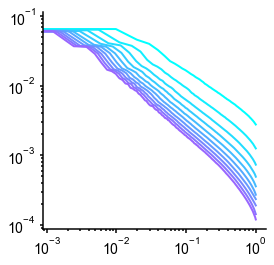

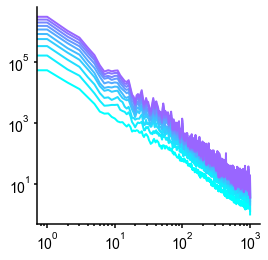

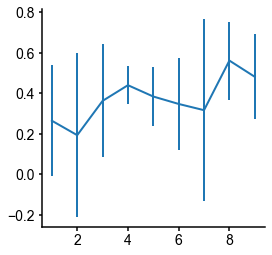

In [31]:
colors = list(iter(plt.cm.cool(np.linspace(0, 1, 16))))

for i, spec in enumerate(sim_data['2.37']['data']['eigs']):
    plt.loglog(np.linspace(0, 1, len(spec)), spec, color=colors[i])
plt.figure()

for i, spec in enumerate(sim_data['2.37']['data']['pows']):
    plt.loglog(spec, color=colors[i])
    
    
plt.figure()
corr = sim_data['2.27']['data']['pearson_corr2'].T
x = list(range(len(corr)))
plt.errorbar(x[1:-1],corr[1:-1].mean(1), corr[1:-1].std(1))
# plt.plot(sim_data['2.27']['data']['pearson_corr1'].T)


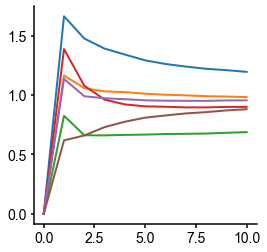

In [30]:
for t in sample_temps:
    plt.plot(sim_data[t]['data']['es_exponent'].mean(0))

# where I left off:
### there are nans in e-spec because fitting range is too small, especially when lower PCs are knee-like

In [83]:
from joblib import Parallel, delayed, cpu_count


sample_temp = '2.27'
pc_range = [0, 0.1]
n_pc = 0.8
n_iter = 4
es_fooof_kwargs = {'return_params': [['aperiodic_params', 'exponent']],
    'fit_kwargs': {'aperiodic_mode': 'knee'}}
data = ising.tensor_to_raster(ising_h5[sample_temp], keep=1024)
subset_sizes = np.linspace(100, data.shape[1], 10, dtype=int)
n_subsets     = len(subset_sizes)
e_exponents = np.zeros((n_iter, n_subsets))
eigs = []
fits = []
for i, num in enumerate(subset_sizes):
    n_pc_curr = int(n_pc*num)

    # [0,None] for whole range, otherwise check if float for fraction
    if pc_range == [0,None]:
        pc_range_curr = [0, int(min(.5*n_pc_curr, .25*max(subset_sizes*n_pc)))]
    elif isinstance(pc_range[1], float): # cut up to percent
        pc_range_curr = [pc_range[0], int(n_pc_curr*pc_range[1])]
    # DEBUG can't fooof fit if range is too small
    if pc_range_curr[1] < 3:
        print(f'    skipping subset {num}')
        continue
        

    #random_subset_decomp
    def parallel_task():
        loc_array = np.sort(np.random.choice(data.shape[1], num, replace=False))
        subset = np.array(data.iloc[:,loc_array])
        return ramsey.pca(subset, n_pc_curr)
    eigs_subset = Parallel(n_jobs=n_iter)(delayed(parallel_task)() for _ in range(n_iter)) # 2d array shape n_iter x n_pc_curr
    
    eigs_subset = np.array(eigs_subset)
    es_fit = ramsey.fooofy(np.arange(n_pc_curr), eigs_subset, pc_range_curr, **es_fooof_kwargs)['exponent']
    eigs.append(eigs_subset)
    fits.append(es_fit)

In [324]:
ramsey.fooofy(np.arange(n_pc_curr), eigs_subset, pc_range_curr, **es_fooof_kwargs)['exponent']

array([1.38925758, 1.38925741, 1.38925764, 1.38925743])

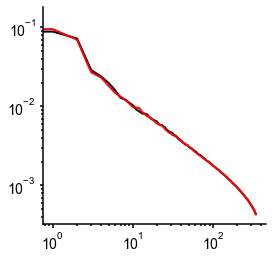

In [341]:
plt.loglog(np.arange(size), eigs[0][0], color='k')
plt.loglog(np.arange(size), eigs[0][1], color='r')



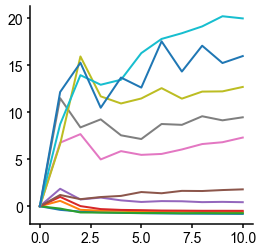

In [62]:
for t in all_temps:
    plt.plot(sim_data[t]['data']['es_knee'][-1])

# why are there only 10 on chart?>

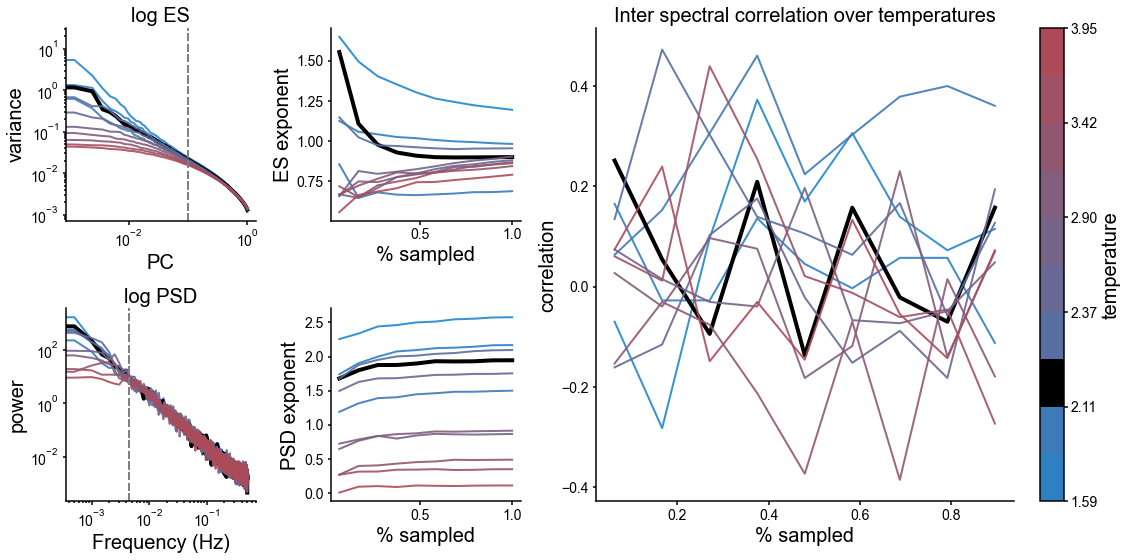

In [195]:

import os

# sample_temps = sorted(list(set(sim_data.keys()) - {'meta'})) # want to `avoid big drop off with very low temps
fig = plt.figure(figsize=(16,8))
gs = GridSpec(2,3, width_ratios=[1,1, 2.75])

for (i, spec), labels in zip(enumerate(['eigs', 'pows']), 
                           [['log ES','PC', 'variance'], ['log PSD','Frequency (Hz)', 'power']]):
    ax = fig.add_subplot(gs[i, 0])
    plot_ising_spectra(sim_data, spec, sample_temps, subset_ix=9, ax=ax)
    pltlabel(*labels, size=20)

for (i, spec), labels in zip(enumerate(['es_exponent', 'psd_exponent1']), 
                           [['','% sampled', 'ES exponent'], ['','% sampled', 'PSD exponent']]):
    ax = fig.add_subplot(gs[i, 1])
    measure_over_temps(sim_data, spec, all_temps, ax=ax)
    pltlabel(*labels, size=20)
    
ax = fig.add_subplot(gs[:,2])
measure_over_temps(sim_data, 'spearman_corr1', all_temps, ax, colorbar=True)
pltlabel('Inter spectral correlation over temperatures', '% sampled', 'correlation', size=20)
fig.tight_layout()

plt.savefig('../fig/ising/specs_corr.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

# Universality class comparison: psd-espec relationship in ising vs fbm vs mouse
- with mice might have to fix a subsample size to get enough unique time series (also assuming it's a mutant tri-headed mouse)
- by simulating multiple series, essentially it's like subsampling but at 100% each time
- theoretically: how to create a dynamical system that, as you tweak the PSD, how does ES change?

In [47]:
from galaxybrain.ising import metro_ising, T_CRIT
temps = np.sort(np.append(np.linspace(0.01, 5, 20), T_CRIT))


def multi_signal_exponents_ising(temps = None,num = 100,FS=1,nperseg=2000,noverlap=int(.8*2000)):
        """currentkly unused"""
    pca_results = []
    pc_dims = np.arange(1,num+1)

    espec_exp = []
    psd_exp = []

    for temp in temps[3:]:
        signals = []
        for i in range(num):
            tensor  = metro_ising(N=16, T=temp, runtime=10000)
            signals.append(tensor.sum(axis=-1).sum(axis=-1))

        signals = np.array(signals)

        # compute PCA
        evals = pca(signals.T, num) # transpose shape
        pca_results.append(evals)


        # compute FT
        sum_sig = np.array(signals).sum(axis = 0) # now one time series
        freqs, spec = compute_spectrum(sum_sig, FS, nperseg=nperseg, noverlap=noverlap)

        #fit
        psd_exp.append(fooofy(freqs, spec, None, group=False)['exponent'])
        espec_exp.append(fooofy(pc_dims, evals, None, group=False)['exponent'])
        
    return psd_exp, espec_exp
    

normalizing neuron population size?


{'n_iter': 95, 'n_pc': 0.8, 'pc_range': [0, None], 'f_range': [0, 0.4], 'ft_kwargs': {'fs': 1, 'nperseg': 120, 'noverlap': 60.0}}


Text(0, 0.5, 'ES exp')

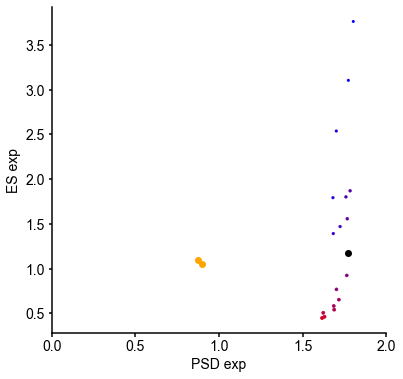

In [59]:
from galaxybrain.plot_utils import rc_style, pltlabel, plot_ising_spectra, measure_over_temps, TEMP_COLOR_RANGE, colorcycler, noticks

# MICE
from galaxybrain.data_utils import load_results, MouseData, ALL_REGIONS
mouse2022 = load_results('/Users/brianbarry/Desktop/computing/personal/galaxybrain/data/experiments/exp_mouse')

mice_es_x = []
mice_psd_x = []
for mouse in ['krebs', 'robbins']:
    mice_es_x.append(mouse2022[mouse]['all']['data']['es_exponent'][0][-1])
    mice_psd_x.append(mouse2022[mouse]['all']['data']['psd_exponent1'][0][-1])

COLORS = colorcycler(['blue', 'red'], len(temps), default=False)
lws = {T_CRIT:4}
cs = {T_CRIT:'k'}

plt.figure(figsize=(6,6))
for px, ex, c, t  in zip(psd_exp, espec_exp, COLORS, temps):
    plt.scatter(px, ex, color=cs.get(t,c), lw=lws.get(t,c))
    
for px, ex in zip(mice_psd_x, mice_es_x):
    plt.scatter(px, ex, color='orange', lw=4)
    
plt.xlim([0,2])
plt.xlabel('PSD exp')
plt.ylabel('ES exp')

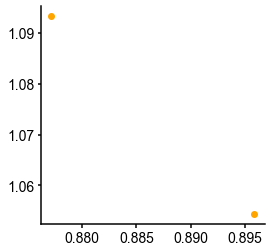

In [56]:
for px, ex in zip(mice_psd_x, mice_es_x):
    plt.scatter(px, ex, color='orange', lw=4)